## Imports and settings

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import json
from pprint import pprint
import collections

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm as CM
import numpy as np
import ipywidgets as widgets
from matplotlib import gridspec
from scipy.stats import gaussian_kde
from tqdm import tqdm

project_root = '..'
sys.path.append(project_root)

from sleeprnn.data.loader import load_dataset, RefactorUnpickler
from sleeprnn.data import utils, stamp_correction
from sleeprnn.detection.feeder_dataset import FeederDataset
from sleeprnn.detection import metrics
from sleeprnn.detection.postprocessor import PostProcessor
from sleeprnn.common import constants, pkeys

SEED_LIST = [123, 234, 345, 456]
RESULTS_PATH = os.path.join(project_root, 'results')
COMPARISON_PATH = os.path.join(project_root, 'resources', 'comparison_data')
DPI = 200
CUSTOM_COLOR = {'red': '#c62828', 'grey': '#455a64', 'blue': '#0277bd', 'green': '#43a047'} 

%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Scaling

In [5]:
# Model: BSF Mixed
ckpt_folder = os.path.join(
        '20190605_grid_v15_v16_n2_train_mass_ss',
        'v15_timef_64_128_256_cwtf_32_32_fb_0.5')
id_try = 0
optimal_thr_list = [0.46, 0.52, 0.62, 0.42]
dataset_name = constants.MASS_SS_NAME
task_mode = constants.N2_RECORD
which_expert = 1
set_name = constants.TRAIN_SUBSET

# ---- Load stuff
scaling_optimal_thr = optimal_thr_list[id_try]
prediction_folder = os.path.join(RESULTS_PATH, 'scaling_results', ckpt_folder, 'seed%d' % id_try)
filenames = os.listdir(prediction_folder)
filenames = [fn for fn in filenames if set_name in fn]
filenames.sort()
scale_list = [float(single_filename[-8:-4]) for single_filename in filenames]
scale_list = np.array(scale_list)
predictions_dict = {}
for scale, file in zip(scale_list, filenames):
    print('Loading scale %1.2f on file %s' % (scale, file))
    with open(os.path.join(prediction_folder, file), 'rb') as handle:
        predictions_dict[scale] = RefactorUnpickler(handle).load()
print('Optimal thr for scaling experiment %1.2f (seed %d)' % (scaling_optimal_thr, id_try))

dataset = load_dataset(dataset_name)
ids_dict = {
    constants.TRAIN_SUBSET: dataset.train_ids,
    constants.TEST_SUBSET: dataset.test_ids
}

data_inference = FeederDataset(
    dataset, ids_dict[set_name], task_mode, which_expert=which_expert)
this_events = data_inference.get_stamps()

# Measure performance
print('Measuring performance', flush=True)
iou_thr = 0.3
scaling_stats = {}
for scale in scale_list:
    prediction_set = predictions_dict[scale]
    prediction_set.set_probability_threshold(scaling_optimal_thr)
    this_detections = prediction_set.get_stamps()
    scaling_stats[scale] = [
        metrics.by_event_confusion(this_y, this_y_pred, iou_thr=iou_thr) 
        for (this_y, this_y_pred) in zip(this_events, this_detections)]
print('Done')

Loading scale 0.50 on file prediction_n2_train_s0.50.pkl
Loading scale 0.55 on file prediction_n2_train_s0.55.pkl
Loading scale 0.60 on file prediction_n2_train_s0.60.pkl
Loading scale 0.65 on file prediction_n2_train_s0.65.pkl
Loading scale 0.70 on file prediction_n2_train_s0.70.pkl
Loading scale 0.75 on file prediction_n2_train_s0.75.pkl
Loading scale 0.80 on file prediction_n2_train_s0.80.pkl
Loading scale 0.85 on file prediction_n2_train_s0.85.pkl
Loading scale 0.90 on file prediction_n2_train_s0.90.pkl
Loading scale 0.95 on file prediction_n2_train_s0.95.pkl
Loading scale 1.00 on file prediction_n2_train_s1.00.pkl
Loading scale 1.05 on file prediction_n2_train_s1.05.pkl
Loading scale 1.10 on file prediction_n2_train_s1.10.pkl
Loading scale 1.15 on file prediction_n2_train_s1.15.pkl
Loading scale 1.20 on file prediction_n2_train_s1.20.pkl
Loading scale 1.25 on file prediction_n2_train_s1.25.pkl
Loading scale 1.30 on file prediction_n2_train_s1.30.pkl
Loading scale 1.35 on file pred

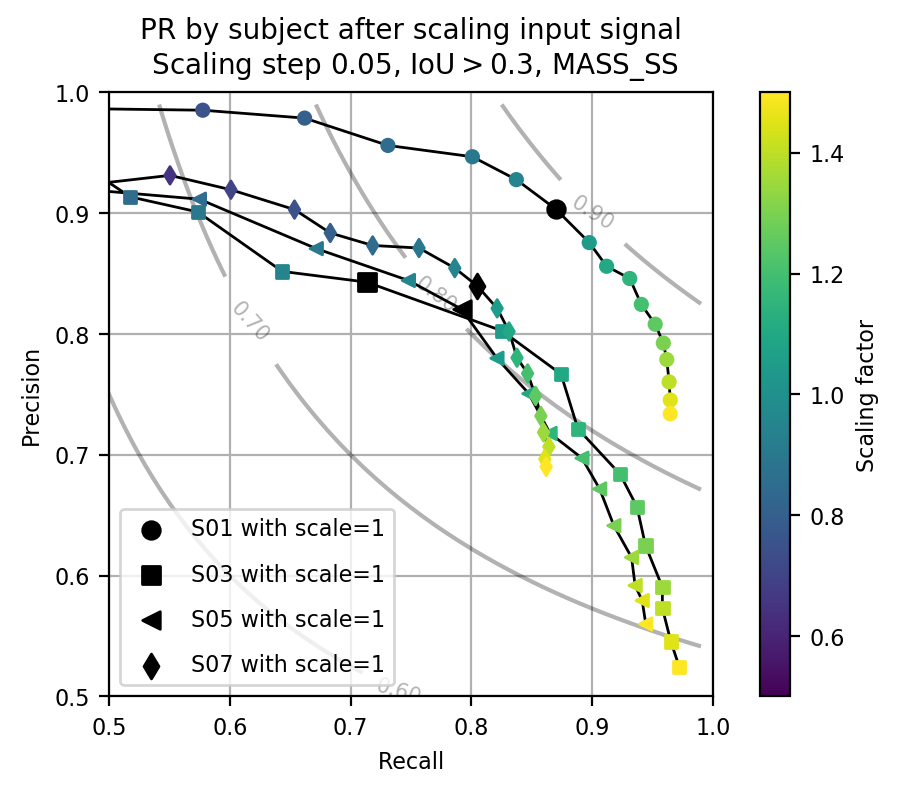

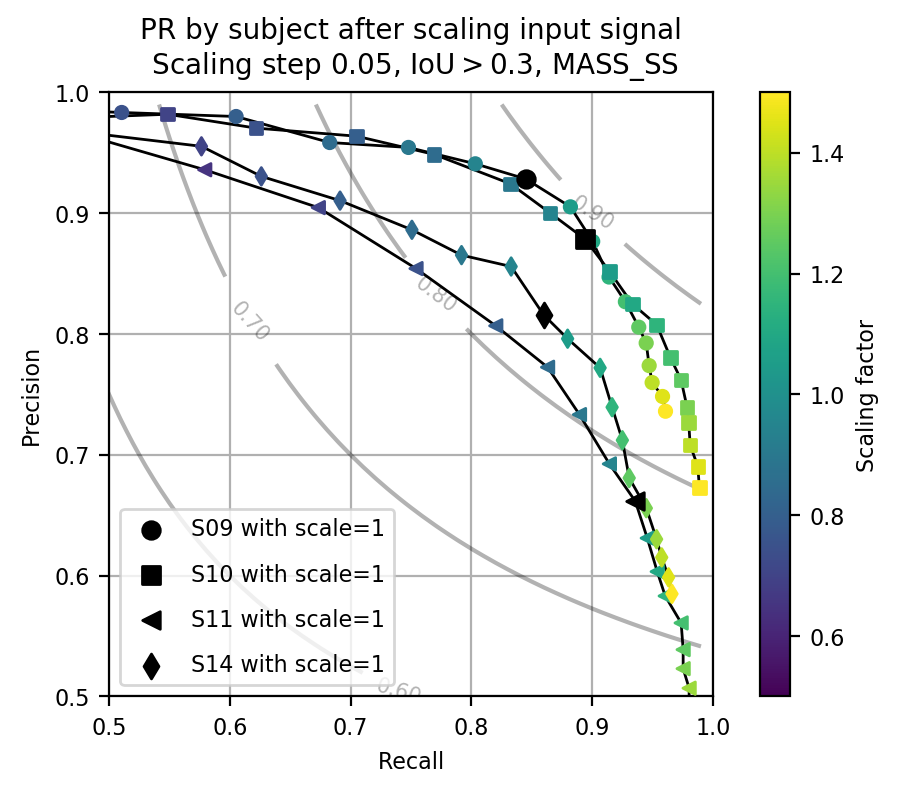

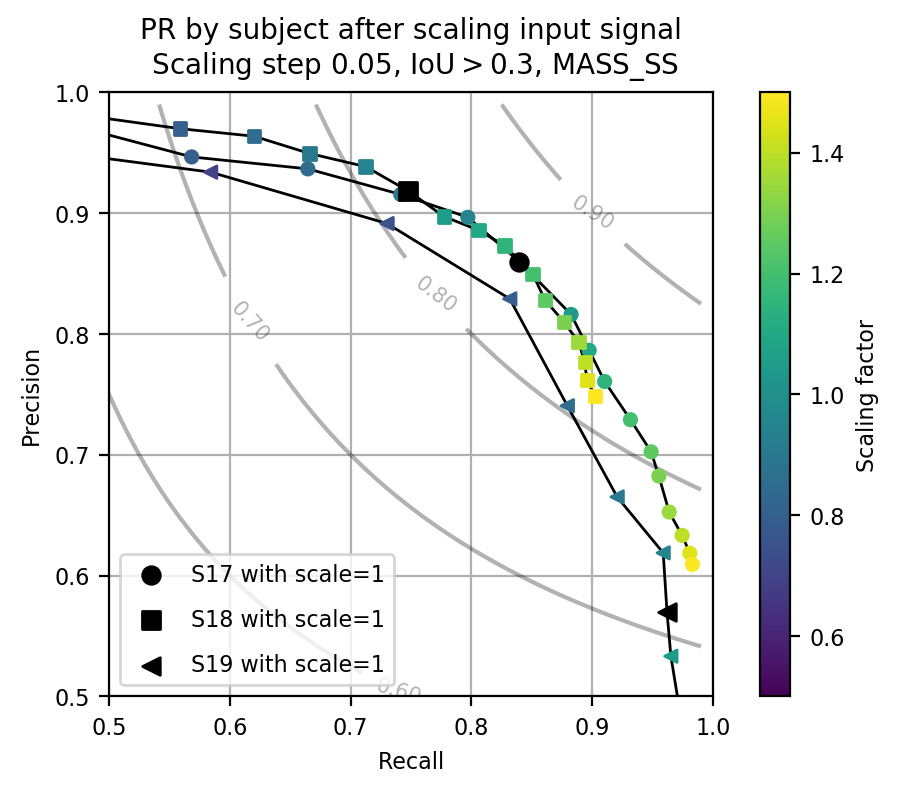

In [10]:
# Plot
if set_name == constants.TEST_SUBSET:
    n_plots = 1
else:
    n_plots = 3

title_fontsize = 10
other_fontsize = 8
markersize = 20
alpha = 0.4
text_space = 0.01
axis_lims = [0.5, 1.0]

# F1 score levels
delta = 0.01 
x_ = np.arange(1, 100) * delta 
y_ = np.arange(1, 100) * delta 
X, Y = np.meshgrid(x_, y_)
Z = 2 * X * Y / (X + Y)
levels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
levels = [level for level in levels if (level>axis_lims[0] and level<axis_lims[1])]

for id_plot in range(n_plots):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=DPI)
    CS = ax.contour(X, Y, Z, colors='k', alpha=0.3, levels=levels)
    ax.clabel(CS, fontsize=7.5, fmt='%1.2f')
    marker_list = ['o', 's', '<', 'd']
    end_range = min(4 * (id_plot+1), len(ids_dict[set_name]))
    for i_inner, i in enumerate(range(id_plot*4, end_range)):
        subject_id = ids_dict[set_name][i]
        this_recall = [scaling_stats[scale][i]['recall'] for scale in scale_list]
        this_precision = [scaling_stats[scale][i]['precision'] for scale in scale_list]
        scat = ax.scatter(this_recall, this_precision, c=scale_list, marker=marker_list[i_inner], cmap='viridis', zorder=10, s=markersize)
        ax.plot(this_recall, this_precision, linewidth=1, color='k', zorder=7)
        recall_at_1 = scaling_stats[1.0][i]['recall']
        precision_at_1 = scaling_stats[1.0][i]['precision']
        ax.scatter(recall_at_1, precision_at_1, color='k', marker=marker_list[i_inner], s=2*markersize, zorder=15, label='S%02d with scale=1' % subject_id)
    ax.axis('square')
    ax.set_title('PR by subject after scaling input signal\n Scaling step %1.2f, IoU$>$%1.1f, %s' % (scale_list[1]-scale_list[0], iou_thr, dataset_name.upper()), fontsize=title_fontsize)
    ax.set_xlabel('Recall', fontsize=other_fontsize)
    ax.set_ylabel('Precision', fontsize=other_fontsize)
    ax.set_xlim(axis_lims)
    ax.set_ylim(axis_lims)

    lg = ax.legend(loc='lower left', labelspacing=1, fontsize=other_fontsize)
    for lh in lg.legendHandles:
        lh.set_alpha(1.0)

    ax.tick_params(labelsize=other_fontsize)
    ax.grid()
    cbar = plt.colorbar(scat)
    cbar.ax.tick_params(labelsize=other_fontsize) 
    cbar.set_label('Scaling factor', fontsize=other_fontsize)
    plt.show()

## Performance Results - Ablation

In [ ]:
ckpt_dict = {}

ckpt_dict['v11'] = {
    os.path.join('20190608_bsf_ablation_n2_train_mass_ss', 'v11_tf_64-128-256_cwtf_None-None/rep0'): [0.56, 0.54, 0.54, 0.48],
    os.path.join('20190608_bsf_ablation_n2_train_mass_ss', 'v11_tf_64-128-256_cwtf_None-None/rep1'): [0.6, 0.58, 0.5, 0.46],
    os.path.join('20190608_bsf_ablation_n2_train_mass_kc', 'v11_tf_64-128-256_cwtf_None-None/rep0'): [0.48, 0.6, 0.68, 0.6],
    os.path.join('20190608_bsf_ablation_n2_train_mass_kc', 'v11_tf_64-128-256_cwtf_None-None/rep1'): [0.54, 0.62, 0.56, 0.58],
    os.path.join('20190608_bsf_ablation_n2_train_inta_ss', 'v11_tf_64-128-256_cwtf_None-None/rep0'): [0.46, 0.5, 0.5, 0.44],
    os.path.join('20190608_bsf_ablation_n2_train_inta_ss', 'v11_tf_64-128-256_cwtf_None-None/rep1'): [0.44, 0.52, 0.48, 0.46],
}
ckpt_dict['v12'] = {
    os.path.join('20190608_bsf_ablation_n2_train_mass_ss', 'v12_tf_None-None-None_cwtf_32-64/rep0'): [0.66, 0.4, 0.56, 0.52],
    os.path.join('20190608_bsf_ablation_n2_train_mass_ss', 'v12_tf_None-None-None_cwtf_32-64/rep1'): [0.58, 0.46, 0.38, 0.46],
    os.path.join('20190608_bsf_ablation_n2_train_mass_kc', 'v12_tf_None-None-None_cwtf_32-64/rep0'): [0.46, 0.52, 0.48, 0.54],
    os.path.join('20190608_bsf_ablation_n2_train_mass_kc', 'v12_tf_None-None-None_cwtf_32-64/rep1'): [0.52, 0.58, 0.52, 0.46],
    os.path.join('20190608_bsf_ablation_n2_train_inta_ss', 'v12_tf_None-None-None_cwtf_32-64/rep0'): [0.46, 0.46, 0.48, 0.5],
    os.path.join('20190608_bsf_ablation_n2_train_inta_ss', 'v12_tf_None-None-None_cwtf_32-64/rep1'): [0.48, 0.48, 0.48, 0.46],
}
ckpt_dict['v15'] = {
    os.path.join('20190608_bsf_ablation_n2_train_mass_ss', 'v15_tf_64-128-256_cwtf_32-32/rep0'): [0.62, 0.62, 0.4, 0.42],
    os.path.join('20190608_bsf_ablation_n2_train_mass_ss', 'v15_tf_64-128-256_cwtf_32-32/rep1'): [0.64, 0.54, 0.6, 0.46],
    os.path.join('20190608_bsf_ablation_n2_train_mass_kc', 'v15_tf_64-128-256_cwtf_32-32/rep0'): [0.68, 0.54, 0.66, 0.52], 
    os.path.join('20190608_bsf_ablation_n2_train_mass_kc', 'v15_tf_64-128-256_cwtf_32-32/rep1'): [0.72, 0.54, 0.44, 0.56],
    os.path.join('20190608_bsf_ablation_n2_train_inta_ss', 'v15_tf_64-128-256_cwtf_32-32/rep0'): [0.48, 0.52, 0.5, 0.5],
    os.path.join('20190608_bsf_ablation_n2_train_inta_ss', 'v15_tf_64-128-256_cwtf_32-32/rep1'): [0.48, 0.52, 0.54, 0.46],
}
task_mode = constants.N2_RECORD
which_expert = 1
dataset_name = constants.INTA_SS_NAME
n_seeds = 4
model_name_list = ['v12', 'v11', 'v15']
model_name_display_dict = {
    'v11': 'Time Domain Model',
    'v12': 'CWT Domain Model',
    'v15': 'Combined Model'
}

dataset = load_dataset(dataset_name)
test_ids = dataset.test_ids
data_test = FeederDataset(
    dataset, test_ids, task_mode, which_expert=which_expert)
this_events = data_test.get_stamps()

predictions_dict = {}
optimal_thr_dict = {}
for model_name in model_name_list:
    predictions_dict[model_name] = []
    optimal_thr_dict[model_name] = []
    this_ckpt_dict = ckpt_dict[model_name]
    useful_keys = [key for key in this_ckpt_dict.keys() if dataset_name in key]
    # Read predictions
    for key in useful_keys:
        for k in range(n_seeds):
            ckpt_path = os.path.abspath(os.path.join(RESULTS_PATH, 'predictions_%s' % dataset_name, key, 'seed%d' % k))
            filename = os.path.join(ckpt_path, 'prediction_%s_test.pkl' % task_mode)
            with open(filename, 'rb') as handle:
                this_pred = RefactorUnpickler(handle).load()
            predictions_dict[model_name].append(this_pred)
            optimal_thr_dict[model_name].append(this_ckpt_dict[key][k])
print('Predictions loaded')

In [ ]:
# Measure AF1 and F1 vs IoU
print('Measuring F1')
af1_dict = {}
f1_vs_iou_dict = {}
iou_list = np.arange(1, 10) * 0.1
for model_name in model_name_list:
    print('Measuring model %s' % model_name, flush=True)
    af1_dict[model_name] = []
    f1_vs_iou_dict[model_name] = []
    for optimal_thr, predictions in zip(optimal_thr_dict[model_name], predictions_dict[model_name]):
        predictions.set_probability_threshold(optimal_thr)
        this_detections = predictions.get_stamps()
        af1_at_thr = metrics.average_metric_with_list(this_events, this_detections, verbose=False)
        af1_dict[model_name].append(af1_at_thr)
        this_f1_vs_iou = metrics.metric_vs_iou_with_list(this_events, this_detections, iou_list)
        f1_vs_iou_dict[model_name].append(this_f1_vs_iou)
# Mean results
mean_af1_dict = {}
mean_f1_vs_iou_dict = {}
for model_name in model_name_list:
    mean_af1 = np.mean(af1_dict[model_name])
    std_af1 = np.std(af1_dict[model_name])
    
    mean_curve = np.stack(f1_vs_iou_dict[model_name], axis=1).mean(axis=1)
    std_curve = np.stack(f1_vs_iou_dict[model_name], axis=1).std(axis=1)
    
    mean_af1_dict[model_name] = (mean_af1, std_af1)
    mean_f1_vs_iou_dict[model_name] = (mean_curve, std_curve)
print('Done')

In [ ]:
round_precision = 2
print('Test AF1 for %s' % dataset_name)
for model_name in model_name_list:
    print('%s: %1.2f +- %1.2f' 
          % (
              model_name_display_dict[model_name].ljust(20), 
              np.round(100*mean_af1_dict[model_name][0], decimals=round_precision), 
              np.round(100*mean_af1_dict[model_name][1], decimals=round_precision)))

In [ ]:
alpha = 0.3
color_list = {'v15': CUSTOM_COLOR['red'] , 'expert': CUSTOM_COLOR['grey'], 'v11': CUSTOM_COLOR['blue'], 'v12': CUSTOM_COLOR['green']}
linewidth = 1.5
markersize = 7
title_fontsize = 10
other_fontsize = 8
show_std = True

# -------------------- P L O T ----------------------    

# Comparison data
compare_expert = dataset.event_name == constants.SPINDLE
if compare_expert:
    expert_f1_curve_mean = np.loadtxt(os.path.join(COMPARISON_PATH, 'expert', 'ss_f1_vs_iou_expert_mean.csv'), delimiter=',')
    expert_f1_curve_std = np.loadtxt(os.path.join(COMPARISON_PATH, 'expert', 'ss_f1_vs_iou_expert_std.csv'), delimiter=',')
    expert_f1_curve_mean = expert_f1_curve_mean[1:, :]
    expert_f1_curve_std = expert_f1_curve_std[1:, :]
    
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=DPI)

# Complete plot
if compare_expert:
    ax.plot(expert_f1_curve_mean[:, 0], expert_f1_curve_mean[:, 1], linewidth=linewidth, 
               label='Expert Performance\nPrivate Dataset\nWarby et al. 2014', color=color_list['expert'])
    ax.plot(expert_f1_curve_mean[:, 0], expert_f1_curve_mean[:, 1], linestyle='none', 
               markersize=markersize, marker='.', color=color_list['expert'])
    ax.fill_between(
        expert_f1_curve_mean[:, 0], 
        expert_f1_curve_mean[:, 1] - expert_f1_curve_std[:, 1], 
        expert_f1_curve_mean[:, 1] + expert_f1_curve_std[:, 1], 
        alpha=alpha, facecolor=color_list['expert'])

for model_name in model_name_list:
    this_name = model_name_display_dict[model_name]
    ax.plot(iou_list, mean_f1_vs_iou_dict[model_name][0], 
               linewidth=linewidth,
               label='%s' % this_name, color=color_list[model_name])
    ax.plot(iou_list, mean_f1_vs_iou_dict[model_name][0], 
               linestyle='none', markersize=markersize, marker='.', 
               color=color_list[model_name])
    if show_std:
        ax.fill_between(iou_list, 
                        mean_f1_vs_iou_dict[model_name][0] - mean_f1_vs_iou_dict[model_name][1], 
                        mean_f1_vs_iou_dict[model_name][0] + mean_f1_vs_iou_dict[model_name][1], alpha=alpha, facecolor=color_list[model_name])


    
ax.set_title('Test Performance (%s)' % dataset_name.upper(), fontsize=title_fontsize)
ax.set_xlim([0.1 - 0.02, 0.9 + 0.02])
ax.set_ylim([0.1 - 0.02, 0.9 + 0.02])
# ax.set_yticks([0.1*i for i in range(1, 10)])
ax.set_xticks([0.1*i for i in range(1, 10)])
ax.tick_params(labelsize=other_fontsize)
ax.set_xlabel('IoU Threshold', fontsize=other_fontsize)
ax.set_ylabel('F1-score', fontsize=other_fontsize)
ax.yaxis.grid()
ax.legend(loc='lower left', labelspacing=1.5, fontsize=other_fontsize)

plt.show()

In [ ]:
# PR
iou_thr = 0.3
res_thr = 0.02
start_thr = 0.1
end_thr = 0.9
n_thr = int(np.round((end_thr - start_thr) / res_thr + 1))
thr_list = np.array([start_thr + res_thr * i for i in range(n_thr)])

pr_curve_dict = {}
for model_name in model_name_list:
    print('Measuring model %s' % model_name, flush=True)
    pr_curve_dict[model_name] = []
    for k, predictions in enumerate(predictions_dict[model_name]):
        pr_curve_dict[model_name].append(np.zeros((n_thr, 2)))
        for i, thr in enumerate(thr_list):
            predictions.set_probability_threshold(thr)
            this_detections = predictions.get_stamps()
            this_stats = [metrics.by_event_confusion(this_y, this_y_pred, iou_thr=iou_thr) 
                        for (this_y, this_y_pred) in zip(this_events, this_detections)]
            this_recall = np.mean([m[constants.RECALL] for m in this_stats])
            this_precision = np.mean([m[constants.PRECISION] for m in this_stats])
            pr_curve_dict[model_name][k][i, 0] = this_recall
            pr_curve_dict[model_name][k][i, 1] = this_precision
print('Done', flush=True)

In [ ]:
# Plot 
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=DPI)
markersize = 6
alpha = 0.3
text_space = 0.01
compare_expert = dataset.event_name == constants.SPINDLE
axis_lims = [0.5, 1.0]
color_list = {'v15': CUSTOM_COLOR['red'] , 'expert': CUSTOM_COLOR['grey'], 'v11': CUSTOM_COLOR['blue'], 'v12': CUSTOM_COLOR['green']}
title_fontsize = 10
other_fontsize = 8

# F1 score levels
delta = 0.01 
x_ = np.arange(1, 100) * delta 
y_ = np.arange(1, 100) * delta 
X, Y = np.meshgrid(x_, y_)
Z = 2 * X * Y / (X + Y)
levels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
levels = [level for level in levels if (level>axis_lims[0] and level<axis_lims[1])]
CS = ax.contour(X, Y, Z, colors='k', alpha=0.3, levels=levels)
ax.clabel(CS, fontsize=7.5, fmt='%1.2f')
    
if compare_expert:
    expert_pr_mean = np.loadtxt(os.path.join(COMPARISON_PATH, 'expert', 'ss_pr_expert_mean.csv'), delimiter=',')
    ax.scatter(expert_pr_mean[0], expert_pr_mean[1], s=50, c=color_list['expert'], zorder=10, label='Expert Performance\nPrivate Dataset\nWarby et al. 2014')
    
for model_name in model_name_list:
    mean_precision = []
    mean_recall = []
    for k, pr_curve in enumerate(pr_curve_dict[model_name]):
        if k == 0:
            label = model_name_display_dict[model_name]
        else:
            label = None
        thr_run = optimal_thr_dict[model_name][k]
        chosen_thr_idx = np.where(np.isclose(thr_list, thr_run))[0].item()
        ax.plot(pr_curve[:, 0], pr_curve[:, 1], linewidth=1, color=color_list[model_name], zorder=7, alpha=alpha, label=label)
        mean_precision.append(pr_curve[chosen_thr_idx, 1])
        mean_recall.append(pr_curve[chosen_thr_idx, 0])
    mean_precision = np.mean(mean_precision)
    mean_recall = np.mean(mean_recall)
    ax.scatter(mean_recall, mean_precision, s=50, c=color_list[model_name], zorder=10)

ax.set_title('Test PR Curve with IoU$>$%1.1f (%s)' % (iou_thr, dataset_name.upper()), fontsize=10)
ax.set_xlabel('Recall', fontsize=8.5)
ax.set_ylabel('Precision', fontsize=8.5)
ax.set_xlim(axis_lims)
ax.set_ylim(axis_lims)

lg = ax.legend(loc='lower left', labelspacing=1, fontsize=6.5)
for lh in lg.legendHandles:
    lh.set_alpha(1.0)

ax.tick_params(labelsize=8.5)
ax.grid()
plt.show()